In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv("C:/Users/user/Downloads/Weather_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["Temperature"] = df["Temperature"].interpolate()

In [3]:
result = adfuller(df["Temperature"])
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = -1.096, p-value = 0.716


In [4]:
df_diff = df["Temperature"].diff().dropna()

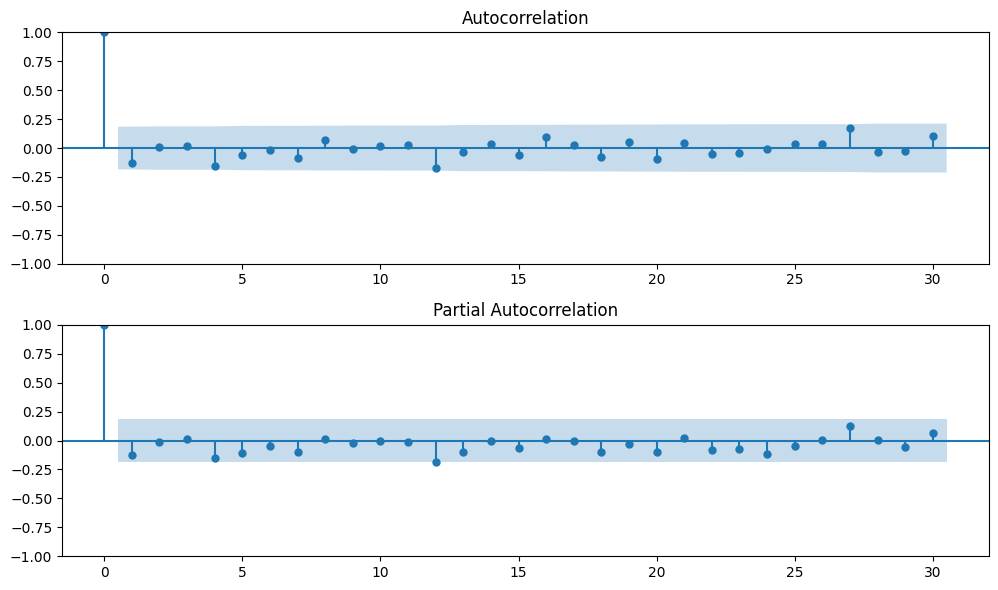

In [5]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df_diff, lags=30, ax=ax[0])
plot_pacf(df_diff, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()

In [6]:
n = len(df_diff)
train_end = int(n * 0.8)
train = df_diff.iloc[:train_end]
test = df_diff.iloc[train_end:]

In [7]:
p = 13
model = AutoReg(train, lags=p, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:            Temperature   No. Observations:                   90
Model:                    AutoReg(13)   Log Likelihood                -146.481
Method:               Conditional MLE   S.D. of innovations              1.622
Date:                Fri, 02 May 2025   AIC                            322.963
Time:                        13:40:28   BIC                            358.120
Sample:                    01-15-2017   HQIC                           337.025
                         - 04-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4366      0.210      2.080      0.038       0.025       0.848
Temperature.L1     -0.1673      0.113     -1.479      0.139      -0.389       0.054
Temperature.L2     -0.0804      

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [9]:
pred_train = model_fit.predict(start=train.index[p], end=train.index[-1], dynamic=False)
pred_test = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [10]:
rmse = np.sqrt(mean_squared_error(test, pred_test))
mae = mean_absolute_error(test, pred_test)
print(rmse, mae,sep="\n")

1.3502853217579163
1.0643731178476408


In [11]:
last_train_value = df["Temperature"].iloc[train_end]
forecast_orig = pred_test.cumsum() + last_train_value
forecast_orig.index = test.index

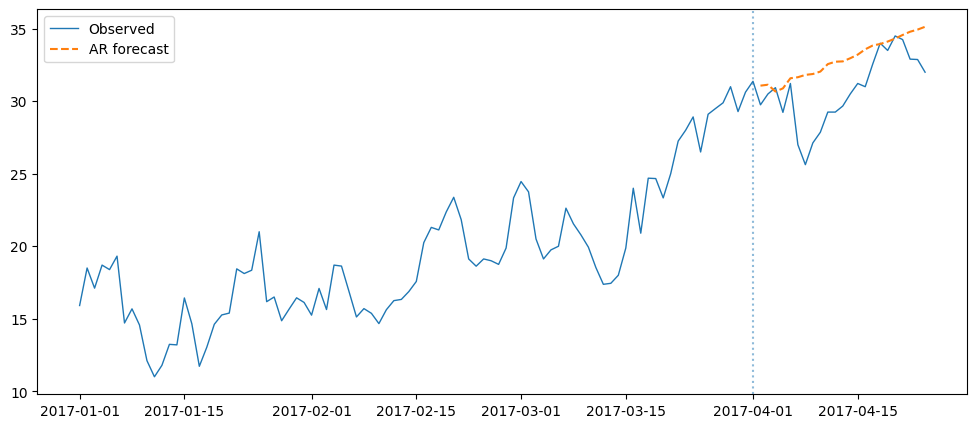

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df["Temperature"], label="Observed", linewidth=1)
plt.plot(forecast_orig, label="AR forecast", linestyle="--")
plt.axvline(df.index[train_end], alpha=0.5, linestyle=":")
plt.legend()
plt.show()